In [8]:
import os
from funman.server.query import FunmanResults
from pathlib import Path
import json
import logging
from IPython.display import Image, display
import glob
import pydantic

# remove matplotlib debugging
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True
logging.getLogger('funman.translate.translate').setLevel(logging.DEBUG)

# %matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

this_dir = Path.cwd()

test_output_dir=os.path.join(
    this_dir, "../scratch/test/out"
)


if not os.path.exists(test_output_dir):
    assert "Test output does not exist"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Results for: e811424e-9b81-4ffc-a596-01486a8a7736
No True points
Results for: 400b046e-7c43-4db8-bd89-227bffbfbe71
No True points
Results for: 84b9301c-0306-4a97-b078-c839f44697d3
No True points
Results for: c48c9ab0-1e70-48b5-9dd6-1c4cdd63b950
No True points
Results for: e0b40997-f35a-45b4-81a5-01de36f8f79f
No True points
Results for: 1b6ac7e2-262b-4f43-845f-252860c3a1b4
No True points
Results for: e0620ed1-e21c-488e-ae40-0f4fc1492d3b
No True points
Results for: f85f2635-a4fb-4314-b009-c80b5990a990
No True points
Results for: bf753ee0-b93f-48ad-8bf2-78c1ab3310a4
No True points
Results for: 6f6536c6-7e84-4aa9-ab52-b60e34e932d9
No True points
Results for: 7aafc4d6-cc1b-458a-bad6-4bdaf08d3ca8
No True points
Results for: 1a009f60-58ba-4137-aaa5-6968774d3354
No True points
Results for: 8d7237a1-4011-4f5f-8ad0-942895219e7a
True point:
Parameters: [{'beta': 0.12254405065281422, 'gamma': 0.129502676331714, 'S0': 0.9375896124884424, 'I0': 0.09103229733374951, 'R0': 0.05}]


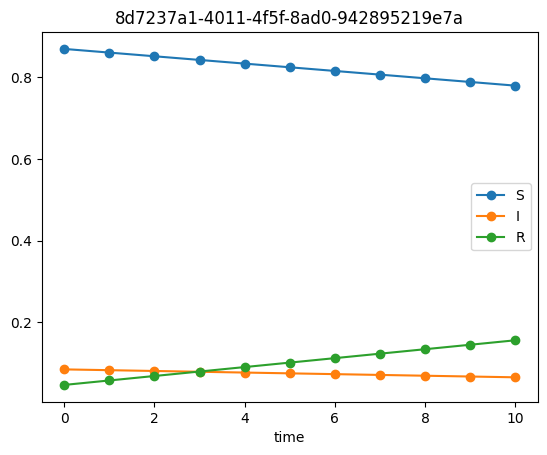

In [23]:
output_files = glob.glob(test_output_dir+"/*.json")

for ofile in output_files:
    result = pydantic.parse_file_as(FunmanResults, ofile)
    print(f"Results for: {result.id}")
    if len(result.parameter_space.true_points) > 0:
        print("True point:")
        parameters = result.model._parameter_names()
        points = result.parameter_space.true_points[0:1]
        point_parameters = [ {param: p.values[param] for param in parameters} for p in points]
        print(f"Parameters: {point_parameters}")
        result.plot(points, variables=result.model._state_var_names(), title=f"{result.id}")
    else:
        print("No True points")

INFO:funman.server.worker:FunmanWorker running...
INFO:funman.server.worker:Starting work on: ff9bdb5a-9726-417a-8ffb-f62aeb4c80da


INFO:funman.server.worker:Completed work on: ff9bdb5a-9726-417a-8ffb-f62aeb4c80da
INFO:funman.server.worker:FunmanWorker exiting...


<Axes: xlabel='time'>

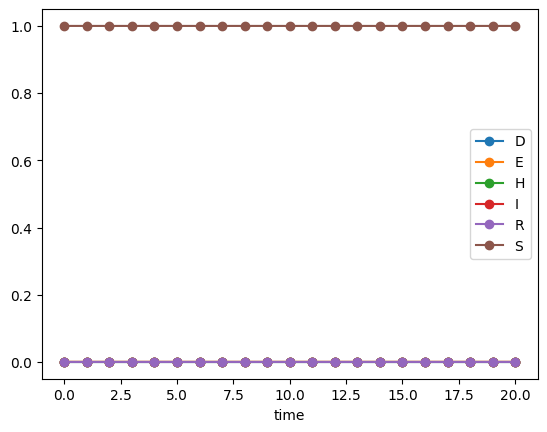

In [5]:

result = Runner().run(model, request, case_out_dir=out_dir)
points = result.parameter_space.true_points[0:1]
result.plot(points, variables=["D", "E", "H", "I", "R", "S"])

In [6]:
point_parameters = [ {param: p.values[param] for param in parameters} for p in points]
point_parameters

[{'N': 19340000.0,
  'beta': 0.4,
  'r_E_to_I': 0.2,
  'p_I_to_R': 0.8,
  'r_I_to_R': 0.07,
  'p_I_to_H': 0.2,
  'r_I_to_H': 0.1,
  'p_H_to_R': 0.88,
  'r_H_to_R': 0.1,
  'p_H_to_D': 0.12000000000000001,
  'r_H_to_D': 0.1}]

In [ ]:
os.system(f"gprof2dot -f pstats {this_dir}/profile.stats | dot -Tpng -o profile.png")
display(Image(filename='profile.png'))

INFO:funman.server.worker:FunmanWorker running...
INFO:funman.server.worker:Starting work on: f48fd935-1054-4ce9-8bfe-ac82bc76c639
INFO:funman.server.worker:Completed work on: f48fd935-1054-4ce9-8bfe-ac82bc76c639
INFO:funman.server.worker:FunmanWorker exiting...
[{'N': 19340000.0, 'beta': 0.5, 'r_E_to_I': 0.5, 'p_I_to_R': 0.5, 'r_I_to_R': 0.5, 'p_I_to_H': 0.5, 'r_I_to_H': 0.5, 'p_H_to_R': 0.5, 'r_H_to_R': 0.5, 'p_H_to_D': 0.5, 'r_H_to_D': 0.5}]


<Axes: xlabel='time'>

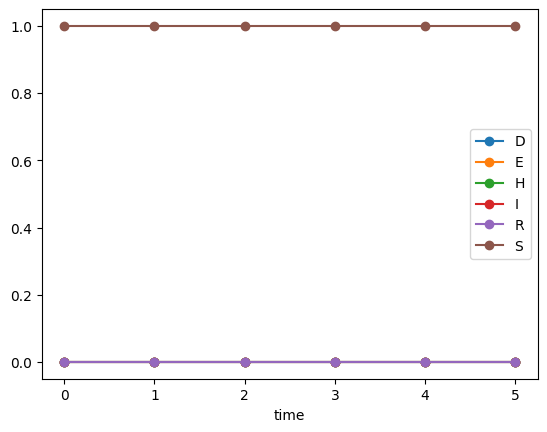

In [12]:
# Relax the parameters to see if an alternative parameterization would work.
model = base_model
request = base_request.copy()
request["parameters"] = [
    {
        "name": param,
        "label": "any",
        "lb": 0.0,
        "ub": 1.0
    } for param in parameters if param != "N"
]
request["config"]["profile"] = True
# request["config"]["substitute_subformulas"] = True
# request["config"]["simplify_query"] = True

# Restrict attention to area where the important behavior occurs
num_steps_param = next(p for p in request["structure_parameters"] if p["name"] == "num_steps")
num_steps_param["lb"]= 5
num_steps_param["ub"]= 5

result = Runner().run(model, request, case_out_dir=out_dir)
points = result.parameter_space.true_points[0:1]
point_parameters = [ {param: p.values[param] for param in parameters} for p in points]
print(point_parameters)

result.plot(points, variables=["D", "E", "H", "I", "R", "S"])


In [ ]:

os.system(f"gprof2dot -f pstats {this_dir}/profile.stats | dot -Tpng -o profile.png")
display(Image(filename='profile.png'))